In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:
# Load data
file_path = '/content/BangloreDATA.csv'
data = pd.read_csv(file_path)


print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15706 entries, 0 to 15705
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YEAR          15706 non-null  int64  
 1   MO            15706 non-null  int64  
 2   DY            15706 non-null  int64  
 3   WS2M          15706 non-null  float64
 4   T2M           15706 non-null  float64
 5   TS            15706 non-null  float64
 6   T2M_RANGE     15706 non-null  float64
 7   T2M_MAX       15706 non-null  float64
 8   T2M_MIN       15706 non-null  float64
 9   PRECTOTCORR   15706 non-null  float64
 10  RH2M          15706 non-null  float64
 11  QV2M          15706 non-null  float64
 12  PS            15706 non-null  float64
 13  WS10M         15706 non-null  float64
 14  WS50M         15706 non-null  float64
 15  WD50M         15706 non-null  float64
 16  WD10M         15706 non-null  float64
 17  RainToday     15706 non-null  int64  
 18  RainTomorrow  15706 non-nu

In [ ]:
# Correlation with RainTomorrow
correlation_matrix = data.corr()
target_correlation = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

print("Top correlated features with RainTomorrow:")
print(target_correlation.head(10))

seasonal_features = ['RainToday','QV2M', 'RH2M', 'WD50M','WD10M','T2M_MIN' ]
target = 'RainTomorrow'


Top correlated features with RainTomorrow:
RainTomorrow    1.000000
RainToday       0.727364
QV2M            0.698980
RH2M            0.538817
WD50M           0.454320
WD10M           0.453894
T2M_MIN         0.450306
MO              0.348517
PRECTOTCORR     0.285438
WS2M            0.195634
Name: RainTomorrow, dtype: float64


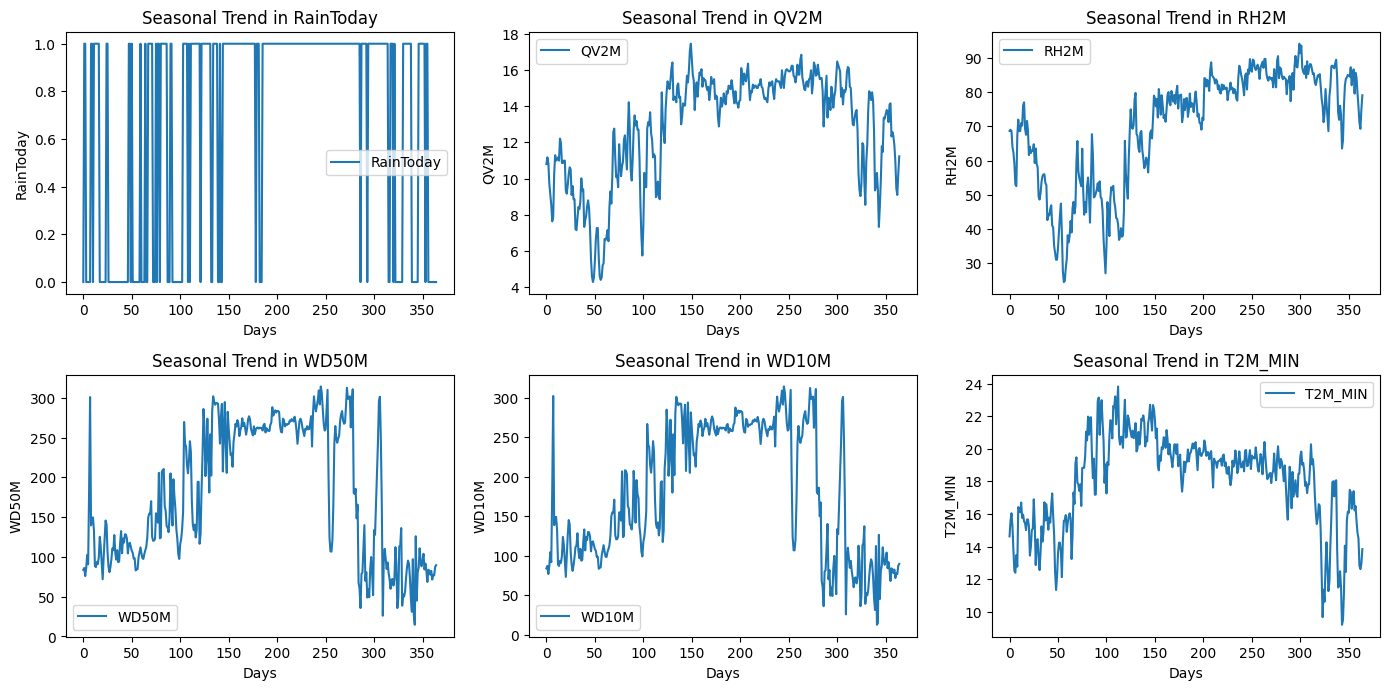

In [ ]:
plt.figure(figsize=(14, 10))
for i, feature in enumerate(seasonal_features, 1):
    plt.subplot(3, 3, i)  
    plt.plot(data[feature][:365], label=feature)  
    plt.title(f'Seasonal Trend in {feature}')
    plt.xlabel('Days')
    plt.ylabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
X = data[seasonal_features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)


scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")


Train shape: (12564, 6), Test shape: (3142, 6)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


y_train_labels = np.argmax(y_train_categorical, axis=1)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)


class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")


Class weights: {0: 1.3250369120438725, 1: 0.803016745494056}


In [ ]:
sequence_length = 30

X_train_sequences = []
y_train_sequences = []
X_test_sequences = []
y_test_sequences = []


for i in range(sequence_length, len(X_train_scaled)):
    X_train_sequences.append(X_train_scaled[i-sequence_length:i])  
    y_train_sequences.append(y_train_categorical[i])  


for i in range(sequence_length, len(X_test_scaled)):
    X_test_sequences.append(X_test_scaled[i-sequence_length:i]) 
    y_test_sequences.append(y_test_categorical[i])  


X_train_sequences = np.array(X_train_sequences)
y_train_sequences = np.array(y_train_sequences)
X_test_sequences = np.array(X_test_sequences)
y_test_sequences = np.array(y_test_sequences)

print(f"Train shape: {X_train_sequences.shape}, Test shape: {X_test_sequences.shape}")


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(seasonal_features))))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 128)           69120     
                                                                 
 dropout_16 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 120674 (471.38 KB)
Trainable params: 120

In [ ]:
# Train the model
history = model.fit(X_train_sequences, y_train_sequences, validation_data=(X_test_sequences, y_test_sequences),
                    epochs=30, batch_size=32, verbose=1 ,shuffle=False)


Epoch 1/30
392/392 [==============================] - 20s 43ms/step - loss: 0.4869 - accuracy: 0.7694 - val_loss: 0.4720 - val_accuracy: 0.7866
Epoch 2/30
392/392 [==============================] - 17s 43ms/step - loss: 0.4351 - accuracy: 0.8150 - val_loss: 0.4517 - val_accuracy: 0.7992
Epoch 3/30
392/392 [==============================] - 16s 42ms/step - loss: 0.4169 - accuracy: 0.8251 - val_loss: 0.4473 - val_accuracy: 0.8040
Epoch 4/30
392/392 [==============================] - 17s 42ms/step - loss: 0.4101 - accuracy: 0.8293 - val_loss: 0.4400 - val_accuracy: 0.8101
Epoch 5/30
392/392 [==============================] - 16s 42ms/step - loss: 0.4050 - accuracy: 0.8317 - val_loss: 0.4402 - val_accuracy: 0.8111
Epoch 6/30
392/392 [==============================] - 16s 40ms/step - loss: 0.4035 - accuracy: 0.8317 - val_loss: 0.4360 - val_accuracy: 0.8117
Epoch 7/30
392/392 [==============================] - 15s 39ms/step - loss: 0.4029 - accuracy: 0.8317 - val_loss: 0.4349 - val_accuracy:

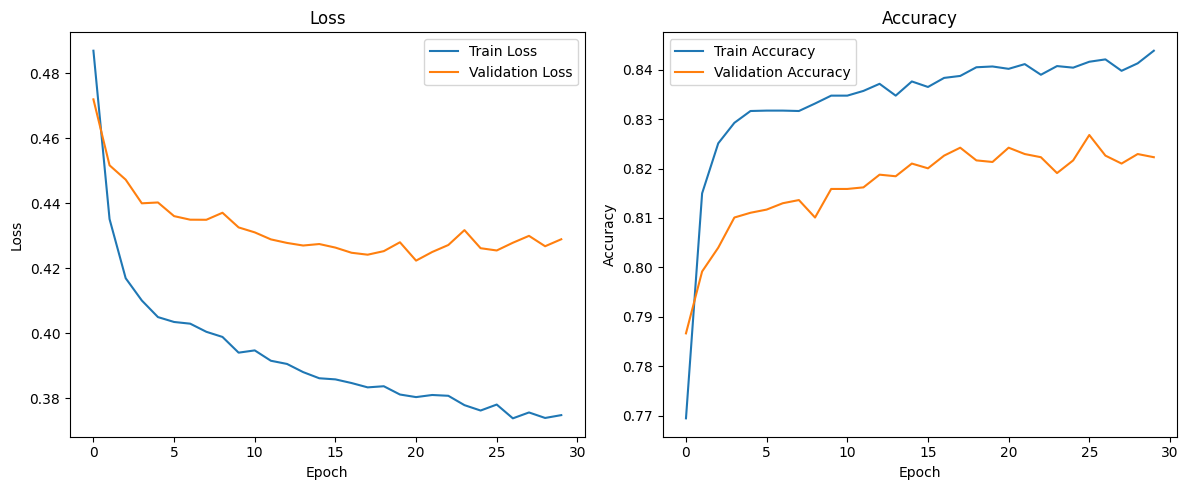

In [ ]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


98/98 [==============================] - 2s 15ms/step


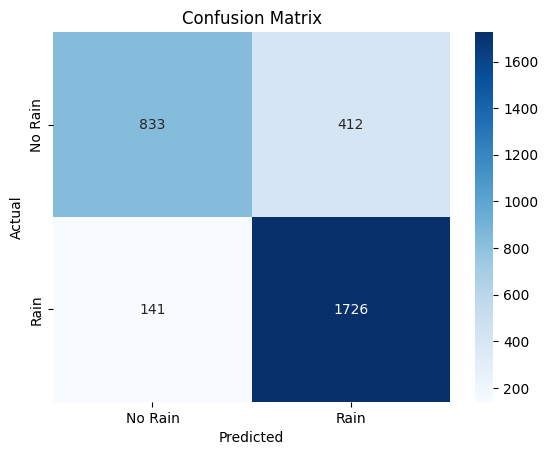

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_sequences, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      1245
           1       0.81      0.92      0.86      1867

    accuracy                           0.82      3112
   macro avg       0.83      0.80      0.81      3112
weighted avg       0.83      0.82      0.82      3112



Model 2 Using class weights


In [ ]:
history = model.fit(X_train_sequences, y_train_sequences, epochs=30, batch_size=32,
          validation_data=(X_test_sequences, y_test_sequences),shuffle=False,
          class_weight=class_weight_dict)


Epoch 1/30
392/392 [==============================] - 20s 43ms/step - loss: 0.5150 - accuracy: 0.7604 - val_loss: 0.4954 - val_accuracy: 0.7831
Epoch 2/30
392/392 [==============================] - 16s 41ms/step - loss: 0.4595 - accuracy: 0.8049 - val_loss: 0.4699 - val_accuracy: 0.7927
Epoch 3/30
392/392 [==============================] - 17s 43ms/step - loss: 0.4383 - accuracy: 0.8193 - val_loss: 0.4615 - val_accuracy: 0.7985
Epoch 4/30
392/392 [==============================] - 16s 41ms/step - loss: 0.4297 - accuracy: 0.8230 - val_loss: 0.4543 - val_accuracy: 0.8072
Epoch 5/30
392/392 [==============================] - 17s 43ms/step - loss: 0.4230 - accuracy: 0.8258 - val_loss: 0.4498 - val_accuracy: 0.8062
Epoch 6/30
392/392 [==============================] - 16s 41ms/step - loss: 0.4228 - accuracy: 0.8239 - val_loss: 0.4505 - val_accuracy: 0.8072
Epoch 7/30
392/392 [==============================] - 16s 42ms/step - loss: 0.4212 - accuracy: 0.8238 - val_loss: 0.4429 - val_accuracy:

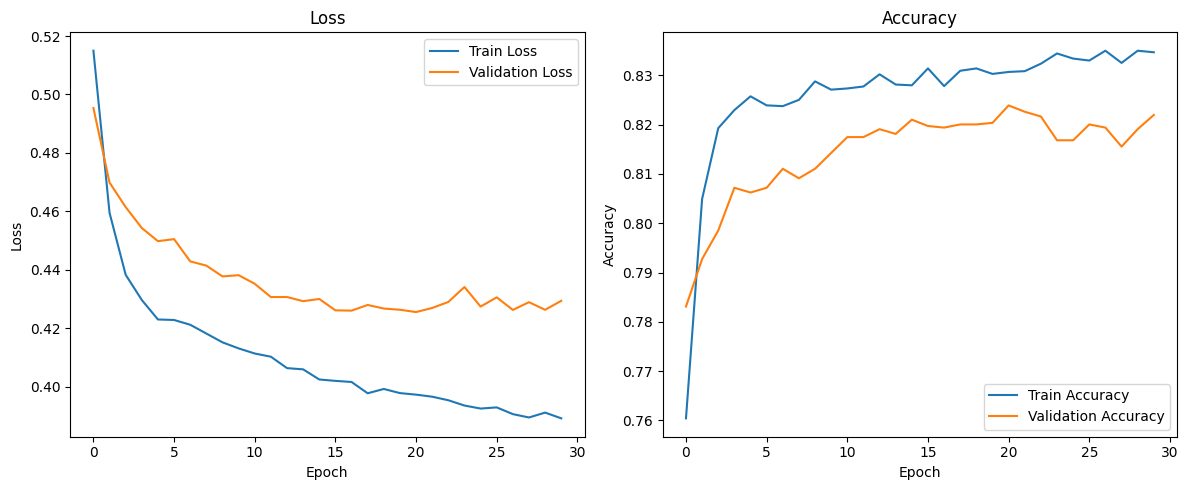

In [ ]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


98/98 [==============================] - 2s 15ms/step


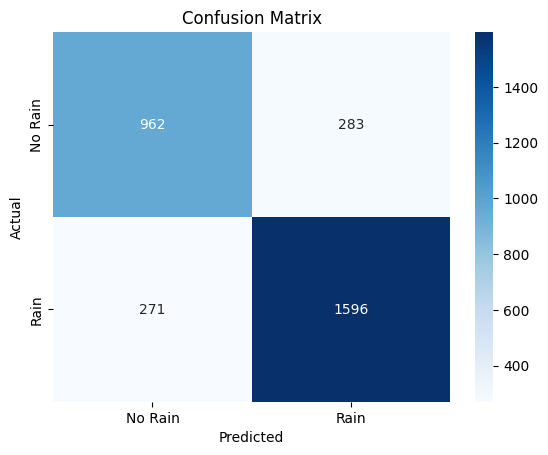

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_sequences, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1245
           1       0.85      0.85      0.85      1867

    accuracy                           0.82      3112
   macro avg       0.81      0.81      0.81      3112
weighted avg       0.82      0.82      0.82      3112

